In [1]:
library(ggplot2)
library(extrafont)
library(stringr)
library(heatmaply)
library(ggrepel)
library(reticulate)
library(gridExtra)
library(robustbase)

Registering fonts with R
Loading required package: plotly

Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout

Loading required package: viridis
Loading required package: viridisLite

Welcome to heatmaply version 0.15.2

Type citation('heatmaply') for how to cite the package.
Type ?heatmaply for the main documentation.

The github page is: https://github.com/talgalili/heatmaply/
Please submit your suggestions and bug-reports at: https://github.com/talgalili/heatmaply/issues
Or contact: <tal.galili@gmail.com>



In [49]:
# Load external Python functions
source_python("reticulate_functions.py")
# Load extra fonts
ttf_import(paths = ".fonts")
loadfonts()
# Set this to true for faster compilation or false for more precise results and all outputs
TEST_MODE = T

Arial already registered with pdfFonts().


In [50]:
# Number of permutations used for empirical p-value computations
PERM_NB_ITER = ifelse(TEST_MODE, 20, 2000)

In [4]:
# Customize ggplot appearance

# Change theme
customTheme <- theme_light() + 
               theme(panel.grid.minor=element_blank(), text=element_text(size=17, family="Arial", colour = "#333333"),
                     line=element_line(colour = "#333333"), legend.background = element_rect(fill=alpha('#CCCCCC', 0.1)), legend.key = element_blank())

# Change default colors
scale_colour_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_colour_gradient(...), 
        viridis = scale_colour_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))
}
scale_color_continuous <- scale_colour_continuous

scale_fill_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_fill_gradient(...), 
        viridis = scale_fill_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))

}

cemm_pal = colorRampPalette(c("#5A463C", "#008CAD", "#40B9D4", "#D4ECF2", "#D2323C", "#F8B100", "#DFDC00"))
cust_pal = colorRampPalette(c("#008CAD", "#40B9D4", "#D4ECF2", "#F8B100", "#C00000", "#2D0000"))
yolla_pal = colorRampPalette(c('#FD0F91', '#C00000', '#2D0000'))
scale_fill_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "fill") 
{
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else if (type == "Yolla"){
        discrete_scale(aesthetics, "Yolla", yolla_pal, na.value = na.value, ...)
    } else if (type == "Cust"){
        discrete_scale(aesthetics, "Cust", cust_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}

scale_color_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "colour") {
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else if (type == "Cust"){
        discrete_scale(aesthetics, "Cust", cust_pal, na.value = na.value, ...)
    } else if (type == "Yolla"){
        discrete_scale(aesthetics, "Yolla", yolla_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", scales::hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}
scale_colour_discrete <- scale_color_discrete

noGridTheme <- function(...){
    theme(panel.grid.major=element_blank(), axis.text.x=element_text(size=12), axis.text.y=element_text(size=12),
                      axis.line=element_line(color="#333333", size = 0.2), panel.border = element_blank(), ...)
}

darkTheme <- function(...){
    theme(panel.background = element_rect(fill = '#333333'), plot.background = element_rect(fill = '#333333'), 
          axis.line=element_line(color="#CCCCCC", size = 0.2), 
          text=element_text(size=17, family="Arial", colour = "#CCCCCC"),
          line=element_line(colour = "#CCCCCC"))
}

theme_set(customTheme)

options(repr.plot.width=10, repr.plot.height=10)

## Load data

In [5]:
N = read.csv("Data/matN.csv", header = F)

In [6]:
R = read.csv("Data/matR.csv", header = F)

In [7]:
PS = read.csv("Data/matPS.csv", header = F)

In [8]:
PR = read.csv("Data/matPR.csv", header = F)

In [9]:
# Assemble into a single data set
dataset = rbind(R,N,PS,PR)

In [10]:
# Remember how these records were generated
origDataset = rep(c("R","N","PS","PR"), c(2000, 1000, 1000, 1000))

## Feature filtering

In [11]:
FILT_MAX_CORR = 0.6 # Keep uncorrelated variables
dimUMAP = 5

In [12]:
# Center and scale on control values
transfNorm <- function(x, y){
    return((x - median(y))/mad(y))
}

In [13]:
normDataset = apply(dataset, 2, function(x) transfNorm(x, x[origDataset == "R"]))

In [17]:
# Order features from biggest mad to smallest mad
# Since features have mad(WT) = 1, it means that we rank features by how more variable they are
# for drug perturbations than for WT
orderFt = rev(order(apply(normDataset, 2, mad)))

In [20]:
uncorrFt = uncorrelate(normDataset, orderCol = orderFt-1, threshold = FILT_MAX_CORR)
uncorrFt = unlist(uncorrFt) + 1

In [21]:
normDataset = normDataset[,uncorrFt]

In [25]:
# Here, no column was correlated
dim(normDataset) == dim(dataset)

[1] TRUE TRUE

## UMAP

In [26]:
# Fix t-SNE layout and random number generation
set.seed(38)

In [27]:
umArti = umap(normDataset, min_dist = 0.1, neighbors = 10, n = dimUMAP, metric = "euclidean")
umArti = as.data.frame(umArti)
names(umArti) = c("UMAP1", "UMAP2")

In [28]:
umArti$Dataset <- origDataset

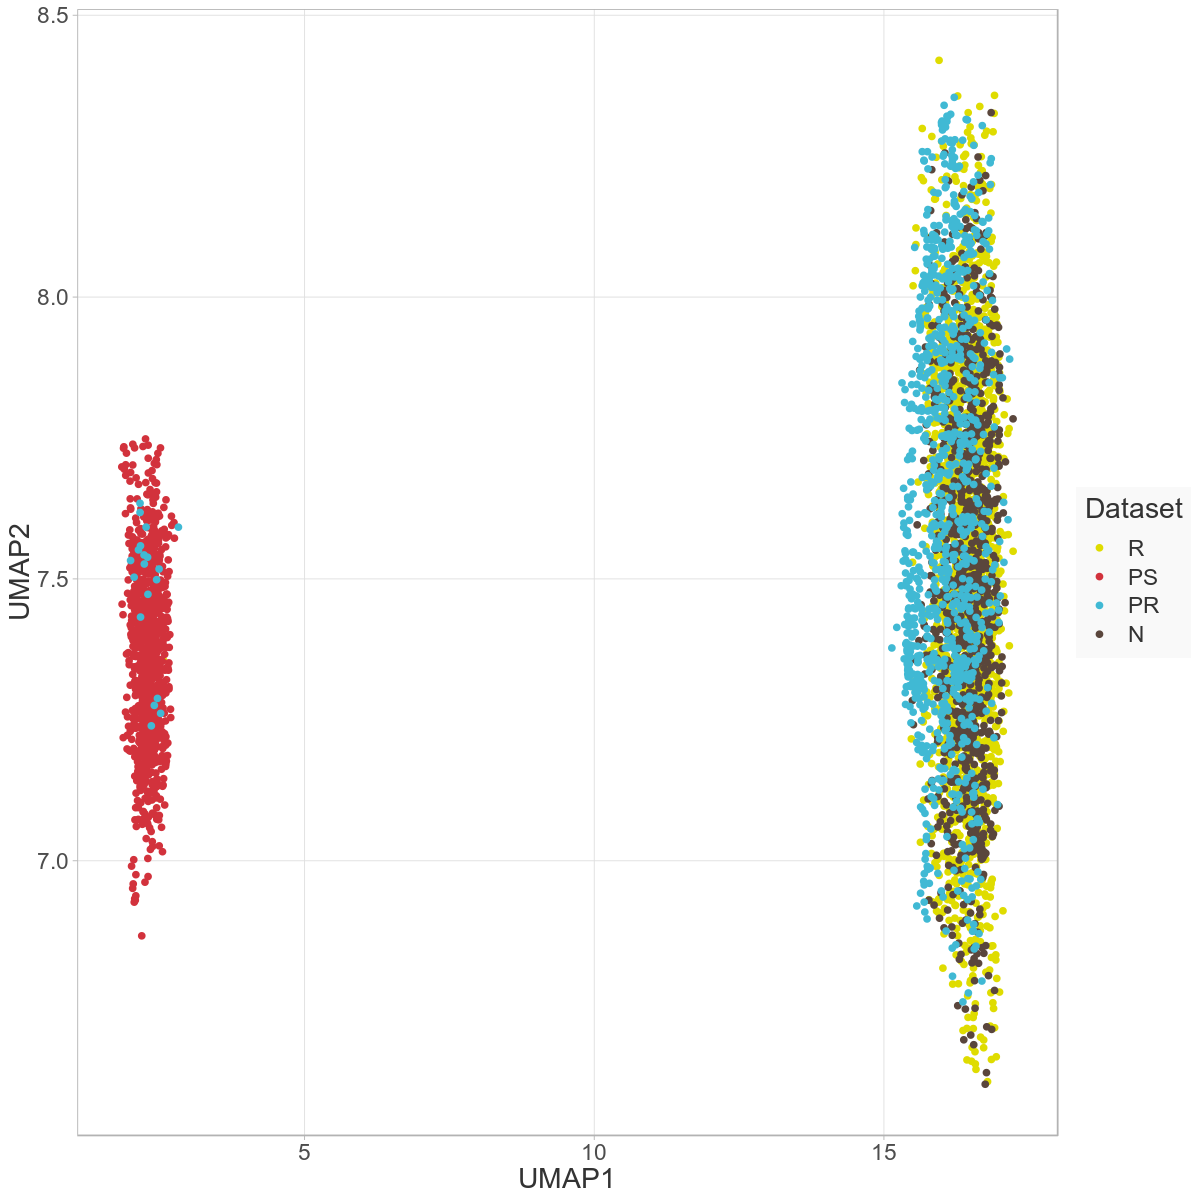

In [29]:
gp <- ggplot(umArti) + geom_point(aes(UMAP1, UMAP2, color = Dataset)) + 
                      guides(color = guide_legend(reverse = TRUE))
gp

## Distances to reference

### Function definition

In [31]:
# Compute the median Robust Mahalanobis Distance (RMD) of perturbation X in constrat to Y
pertRMD <- function(X,Y){
    # Ensure that we have enough points to compute distance
    if ((dim(X)[1] < 2*dimUMAP)|(dim(Y)[1] < 2*dimUMAP)){
            print(drugPert)
            return(NA)
    }
    
    # Compute Minimum Covariance Determinant and corresponding Robust Mahalanobis Distance
    mcdWT = covMcd(Y)
    RMD = median(apply(X, 1, function(x) mahalanobis(x, mcdWT$center, mcdWT$cov)))
    return(RMD)
}

In [53]:
shuffPertRMD <- function(X,Y, nbRep = PERM_NB_ITER){
    set = rbind(X,Y)
    shuffleRMD <- function(notUsed){
        shuffSet = set[sample(nrow(set)),]
        # Take random subsets of corresponding sizes
        shuffX = shuffSet[1:nrow(X),]
        shuffY = shuffSet[(nrow(X)+1):(nrow(X)+nrow(Y)),]
        
        # Ensure that we have enough points to compute distance
        if ((dim(shuffX)[1] < 2*dimUMAP)|(dim(shuffY)[1] < 2*dimUMAP)){
            print(drugPert)
            return(NA)
        }
        
        # Compute Minimum Covariance Determinant and corresponding Robust Mahalanobis Distance
        mcdWT = covMcd(shuffY)
        RMD = median(apply(shuffX, 1, function(x) mahalanobis(x, mcdWT$center, mcdWT$cov)))
        return(RMD)
    }
    return(sapply(1:nbRep, shuffleRMD))
}

In [46]:
getRMPV <- function(x){
    ecdfRMD = ecdf(x[-1])
    return(1 - ecdfRMD(x[1]))
}

## Comparison in artificial dataset

In [30]:
# Fix t-SNE layout and random number generation
set.seed(38)

In [37]:
datasetRMD = sapply(levels(as.factor(origDataset)), 
                    function(set) pertRMD( dataset[origDataset == set,], dataset[origDataset == "R",] ))

In [42]:
X = umArti[,1:dimUMAP]
umapRMD = sapply(levels(as.factor(origDataset)), 
                    function(set) pertRMD( X[origDataset == set,], X[origDataset == "R",] ))

In [54]:
shuffDatasetRMD = sapply(levels(as.factor(origDataset)), 
                    function(set) shuffPertRMD( dataset[origDataset == set,], dataset[origDataset == "R",] ))

In [55]:
shuffUmapRMD = sapply(levels(as.factor(origDataset)), 
                    function(set) shuffPertRMD( X[origDataset == set,], X[origDataset == "R",] ))

In [56]:
datasetRMPV = data.frame(RMPV = apply(rbind(datasetRMD, shuffDatasetRMD), 2, getRMPV))

In [57]:
umapRMPV = data.frame(RMPV = apply(rbind(umapRMD, shuffUmapRMD), 2, getRMPV))

In [58]:
datasetRMPV$Pert = rownames(datasetRMPV)
datasetRMPV$Strength = datasetRMD
datasetRMPV$adjRMPV = p.adjust(datasetRMPV$RMPV, method = "fdr")

In [59]:
umapRMPV$Pert = rownames(umapRMPV)
umapRMPV$Strength = umapRMD
umapRMPV$adjRMPV = p.adjust(umapRMPV$RMPV, method = "fdr")

In [62]:
datasetRMD

N        PR        PS         R 
106.49812 209.25229 169.97843  99.08732

In [65]:
shuffDatasetRMD

N,PR,PS,R
104.5195,110.8312,106.3827,107.3456
105.0788,111.0642,105.5783,104.9460
104.6067,111.3874,105.0686,107.3039
105.5239,111.8118,106.5859,107.1006
105.1132,111.5286,106.5080,105.3828
105.2791,111.3187,105.2421,107.2349
105.3032,109.5259,105.2536,105.1492
105.2688,110.0700,106.2173,106.3016
105.9373,109.8740,104.7386,106.4762
106.2029,110.4018,104.9820,104.7813


Saving 10 x 6.67 in image


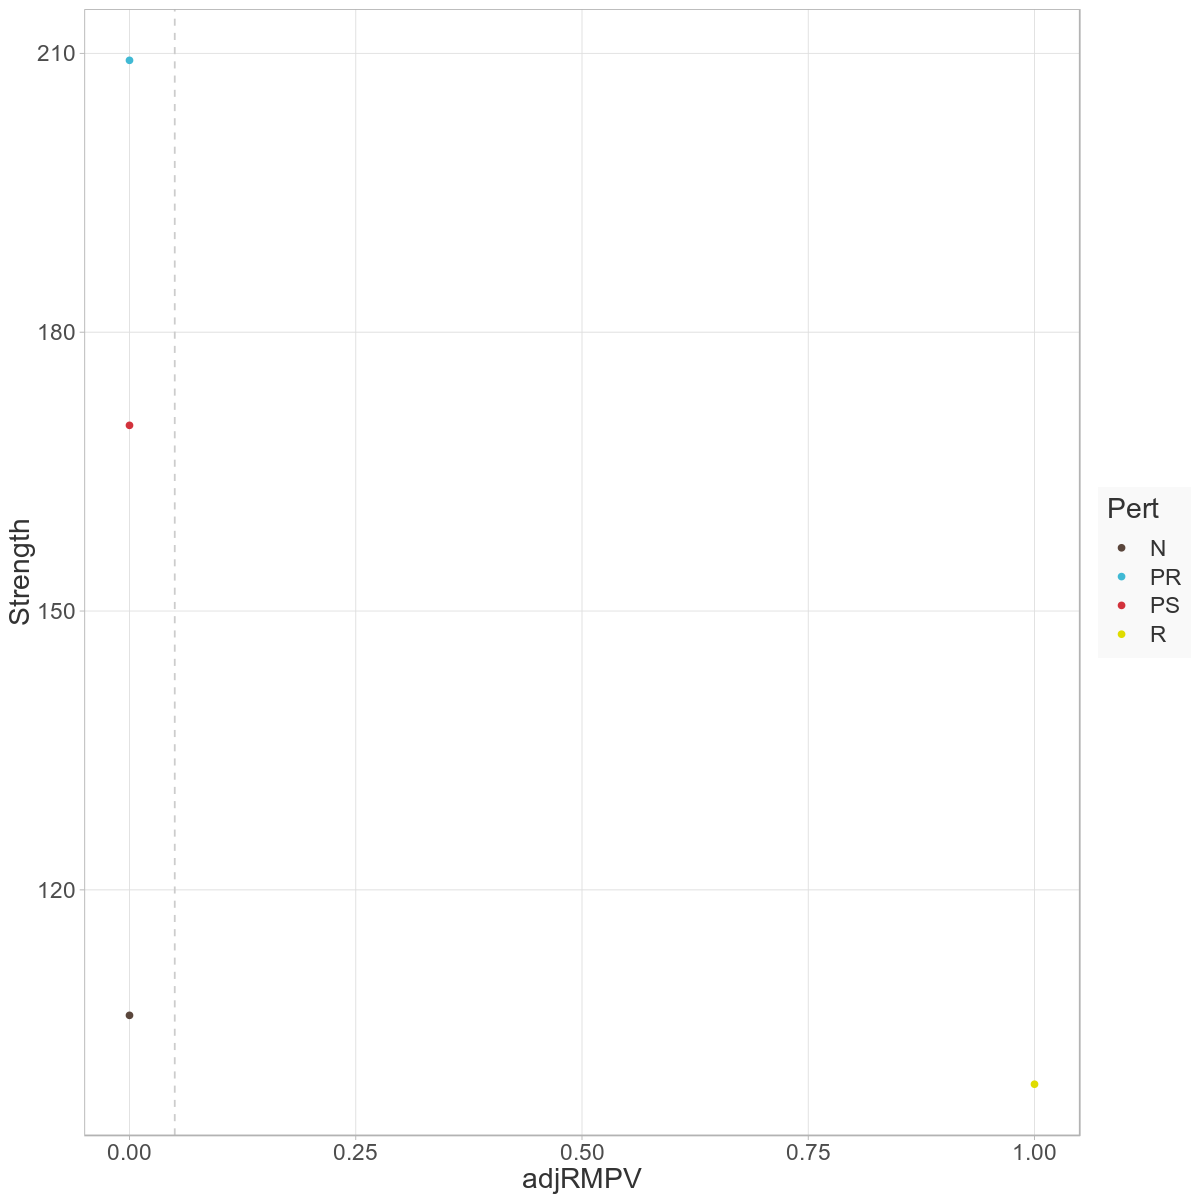

In [60]:
gp <- ggplot(datasetRMPV) + geom_point(aes(adjRMPV, Strength, color = Pert)) + 
      geom_vline(xintercept = 0.05, color="#CCCCCC", linetype="dashed")
gp
ggsave(filename = "Fig/datasetRMPV_20iter.pdf", gp, width = 10)

Saving 10 x 6.67 in image


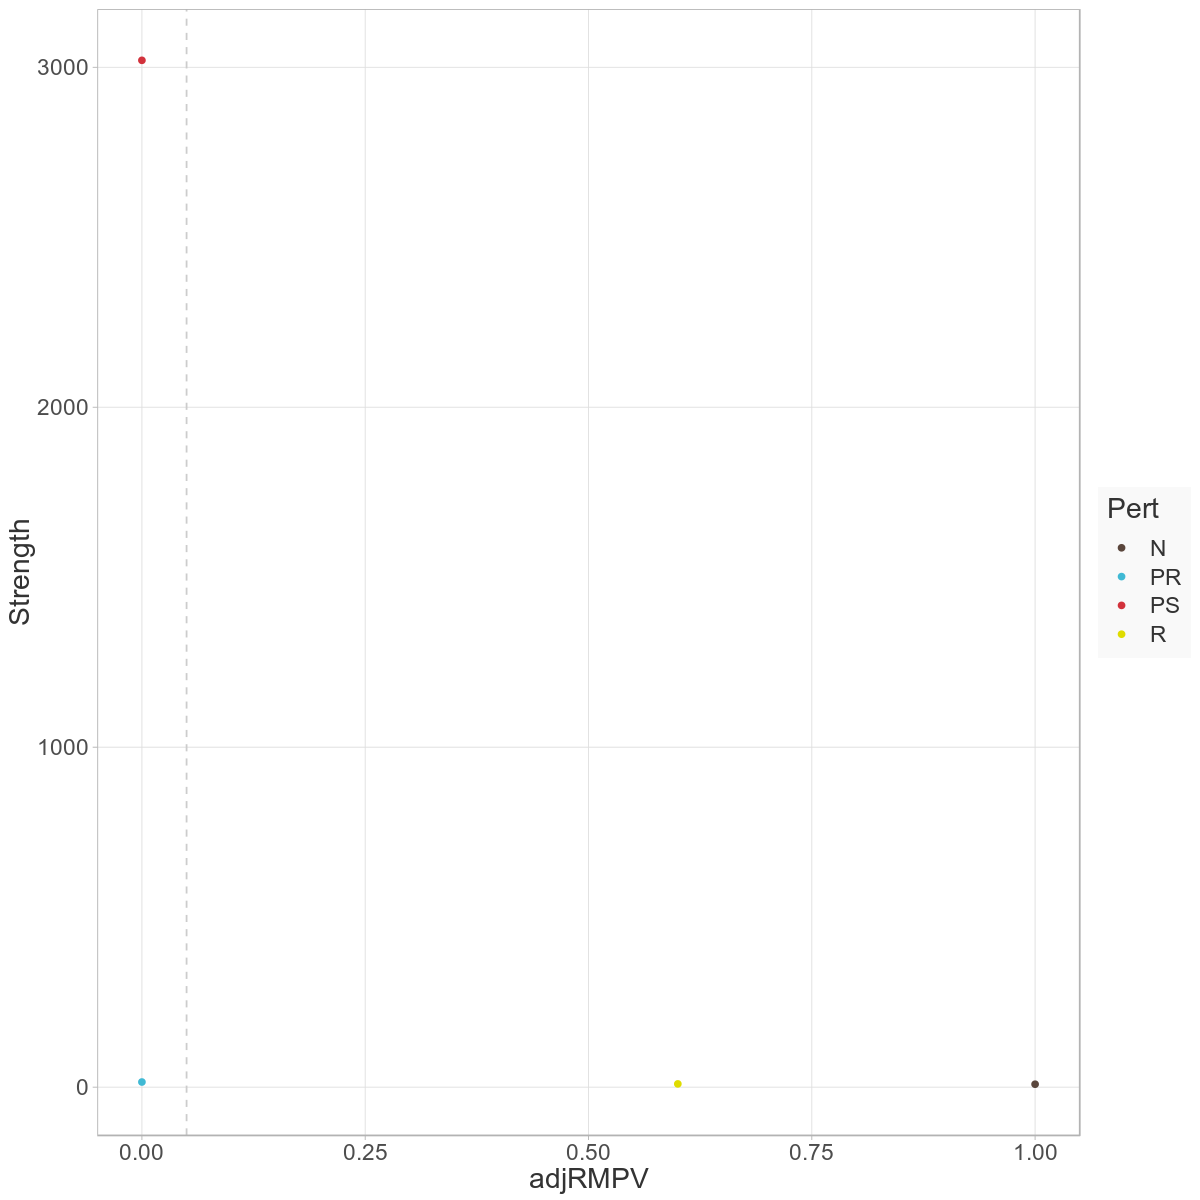

In [61]:
gp <- ggplot(umapRMPV) + geom_point(aes(adjRMPV, Strength, color = Pert)) + 
      geom_vline(xintercept = 0.05, color="#CCCCCC", linetype="dashed")
gp
ggsave(filename = "Fig/umapRMPV_20iter.pdf", gp, width = 10)